In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

## Problem Statement

We want to predict the bitcoin price of day d+1

# Data exploration

In [15]:
data = yf.download('BTC-USD', start="2021-02-05", end="2021-10-19", interval = "1D")
data.sample(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-27,43234.183594,44313.246094,42190.632812,42235.730469,42235.730469,30980029059
2021-04-17,61529.921875,62572.175781,60361.351562,60683.820312,60683.820312,66138759198
2021-03-09,52272.968750,54824.117188,51981.832031,54824.117188,54824.117188,50912227385
2021-05-17,46415.898438,46623.558594,42207.289062,43537.511719,43537.511719,74903638450
2021-10-17,60887.652344,61645.523438,59164.468750,61553.617188,61553.617188,29032367511
2021-02-15,48696.535156,48875.570312,46347.476562,47945.058594,47945.058594,77069903166
2021-05-03,56620.273438,58973.308594,56590.871094,57200.292969,57200.292969,51713139031
2021-03-17,56825.828125,58969.816406,54528.628906,58870.894531,58870.894531,60258313191
2021-09-23,43560.296875,44942.175781,43109.339844,44895.097656,44895.097656,34244064430


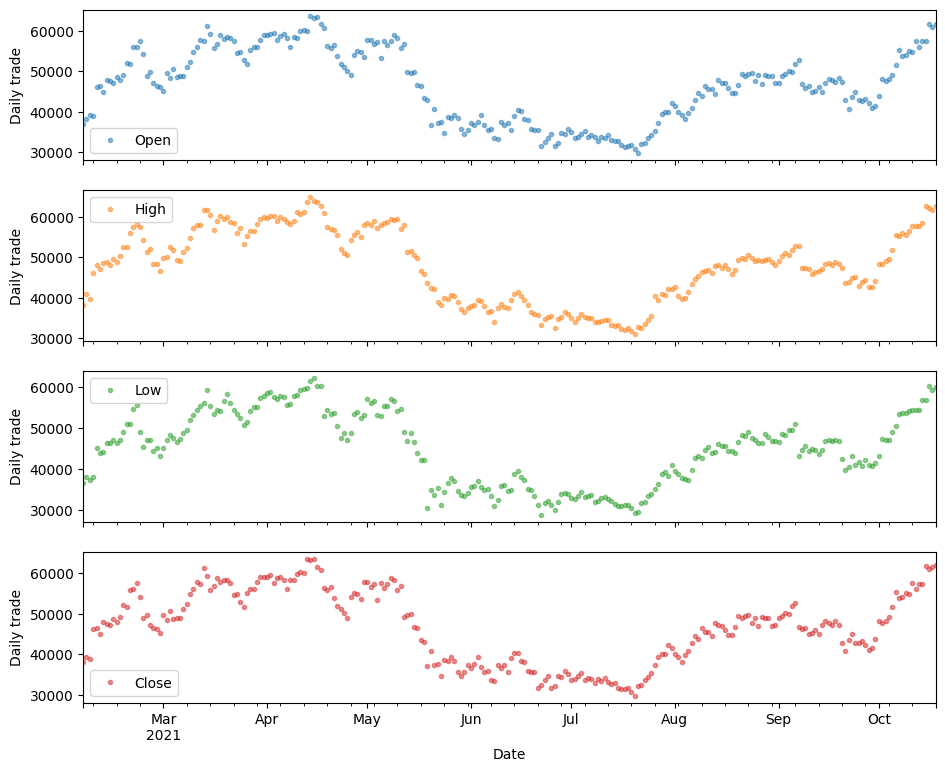

In [16]:
cols_plot = ['Open', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

In [17]:
print(data.shape)
data.head()

(256, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402
2021-02-06,38138.386719,40846.546875,38138.386719,39266.011719,39266.011719,71326033653
2021-02-07,39250.191406,39621.835938,37446.152344,38903.441406,38903.441406,65500641143
2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,46196.464844,101467222687
2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,46481.105469,91809846886


# Model Selection

In [18]:
df= data
X = []
Y = []
window_size=100

for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

123
31


In [19]:
model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=10,batch_size=40, verbose=1, shuffle =True)

Epoch 1/10
4/4 [==============================] - 16s 1s/step - loss: 0.1337 - mse: 0.1337 - mae: 0.3288 - val_loss: 0.1086 - val_mse: 0.1086 - val_mae: 0.2964
Epoch 2/10
4/4 [==============================] - 0s 72ms/step - loss: 0.1056 - mse: 0.1056 - mae: 0.2831 - val_loss: 0.0883 - val_mse: 0.0883 - val_mae: 0.2619
Epoch 3/10
4/4 [==============================] - 0s 75ms/step - loss: 0.0725 - mse: 0.0725 - mae: 0.2310 - val_loss: 0.0682 - val_mse: 0.0682 - val_mae: 0.2277
Epoch 4/10
4/4 [==============================] - 0s 74ms/step - loss: 0.0533 - mse: 0.0533 - mae: 0.1942 - val_loss: 0.0738 - val_mse: 0.0738 - val_mae: 0.2070
Epoch 5/10
4/4 [==============================] - 0s 74ms/step - loss: 0.0528 - mse: 0.0528 - mae: 0.1832 - val_loss: 0.0467 - val_mse: 0.0467 - val_mae: 0.1810
Epoch 6/10
4/4 [==============================] - 0s 46ms/step - loss: 0.0453 - mse: 0.0453 - mae: 0.1591 - val_loss: 0.0401 - val_mse: 0.0401 - val_mae: 0.1677
Epoch 7/10
4/4 [===================

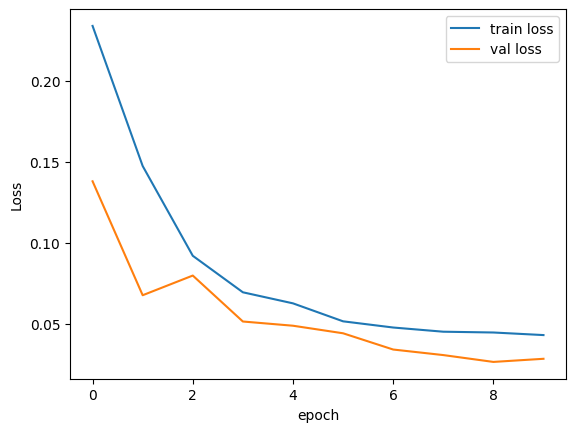

In [7]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

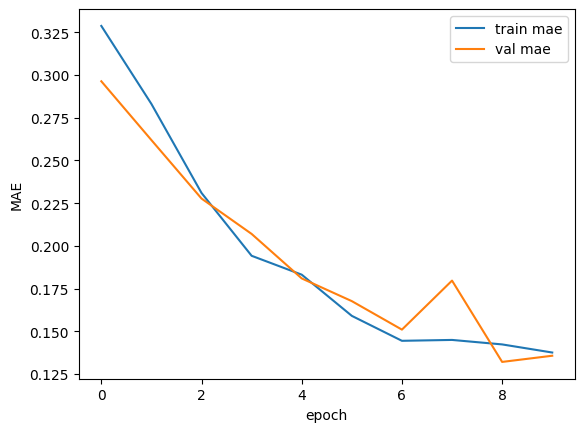

In [20]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("MAE")
plt.legend()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 98, 64)        256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 49, 64)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 47, 128)       24704     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 23, 128)       0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 21, 64)        2

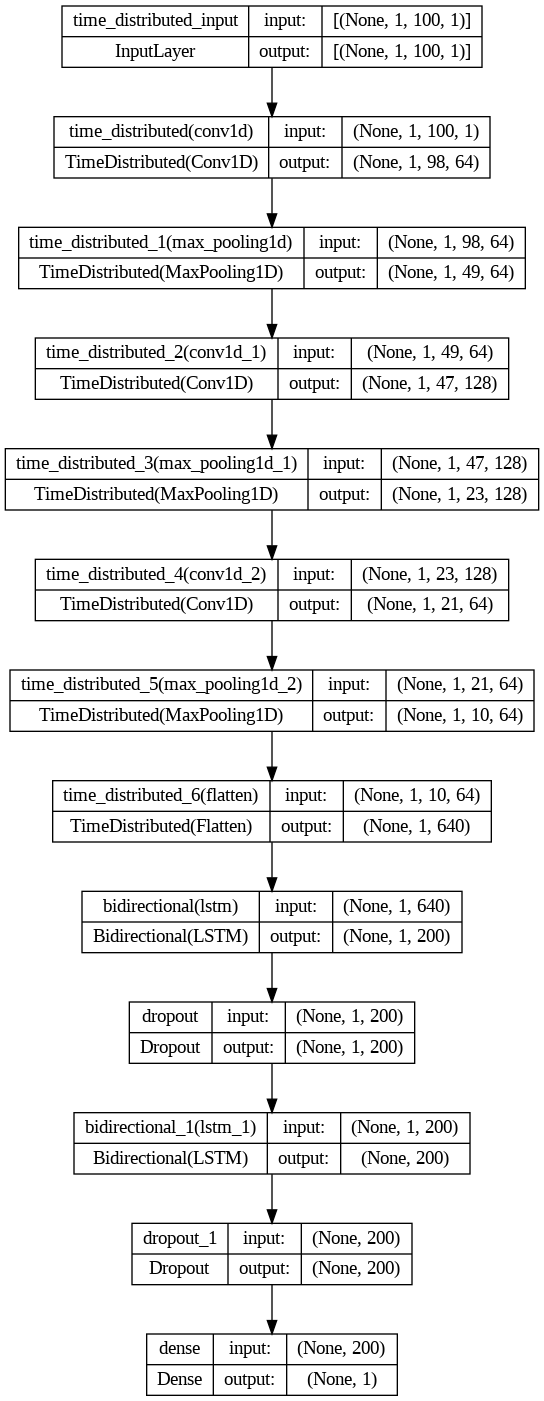

In [9]:
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

1/1 [==============================] - 2s 2s/step


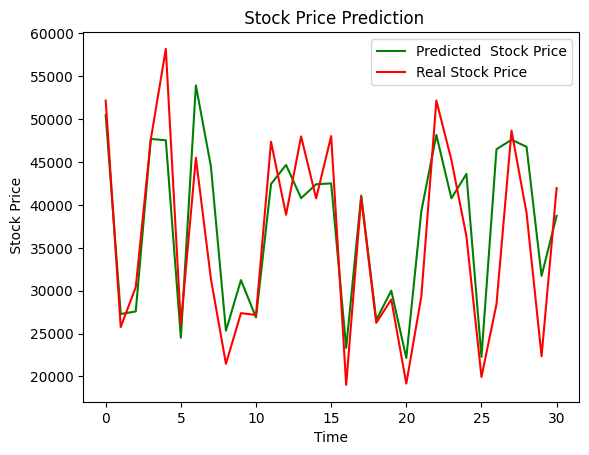

In [21]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

${\displaystyle {\mbox{MAPE}}={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|}$

In [26]:
print(f" MAPE is {round(mean_absolute_percentage_error(test_label, predicted), 3)*100} %")

 MAPE is 14.7 %
